# ANKAN ROY
### Project 1
### MSML602

In [1]:
from urllib.request import urlopen
from urllib.error import HTTPError
from bs4 import BeautifulSoup
import requests
import pandas as pd
import numpy as np
from io import StringIO
from datetime import datetime, timedelta

## Part 1: Data scraping and preparation

In [2]:
# Use request to get the url
try:
    res = requests.get("https://www.spaceweatherlive.com/en/solar-activity/top-50-solar-flares.html")
except HTTPError as e:
    print(e)

# Use BeautifulSoup to parse data as html
soup = BeautifulSoup(res.content, 'html.parser')
print(soup.prettify()[:90]) # I used prettify here to view table structure

<!DOCTYPE html>
<html lang="en">
 <head>
  <title>
   Top 50 solar flares | Solar activity


In [3]:
# Find the table
table = soup.find("table", {"class": "table table-striped"})

# Use pandas to read in the HTML file into a dataframe
df = pd.read_html(StringIO(str(table)))[0]

# Rename columns
df.rename(columns={'Unnamed: 0': 'Rank', 'Unnamed: 1': 'X_Class', 'Unnamed: 2': 'Date', 'Unnamed: 7': 'Movie'}, inplace=True)
df["Region"] = df["Region"].astype(str).str.zfill(4) # I noticed region was being converted to an int (removing 0 in front), so made sure to change it to str

# Print frst 10 items of dataframe
df.head(10)

,Rank,X_Class,Date,Region,Start,Maximum,End,Movie
0,1,X40+,2003/11/04,0486,19:29,19:53,20:06,View archive
1,2,X28.57+,2001/04/02,9393,21:32,21:51,22:03,View archive
2,3,X24.57+,2003/10/28,0486,09:51,11:10,11:24,View archive
3,4,X24.42+,2005/09/07,0808,17:17,17:40,18:03,View archive
4,5,X20.67+,2001/04/15,9415,13:19,13:50,13:55,View archive
5,6,X14.36,2003/10/29,0486,20:37,20:49,21:01,View archive
6,7,X13.3,2017/09/06,2673,11:53,12:02,12:10,View archive
7,8,X12.97,1997/11/06,8100,11:49,11:55,12:01,View archive
8,9,X12.95,2006/12/05,0930,10:18,10:35,10:45,View archive
9,10,X11.96,2003/11/02,0486,17:03,17:25,17:39,View archive


### Step 2: Tidy the top 50 solar flare data

In [4]:
# Drop last column
df.drop("Movie", axis=1, inplace=True)

# Use datetime import to combine the date and each of the three time columns into three datetime columns.
df["Start_datetime"] = df.apply(lambda row: datetime.strptime(row["Date"] + " " + row["Start"], "%Y/%m/%d %H:%M"), axis=1)
df["Maximum_datetime"] = df.apply(lambda row: datetime.strptime(row["Date"] + " " + row["Maximum"], "%Y/%m/%d %H:%M"), axis=1)
df["End_datetime"] = df.apply(lambda row: datetime.strptime(row["Date"] + " " + row["End"], "%Y/%m/%d %H:%M"), axis=1)
df.drop(["Date", "Start", "Maximum", "End"], axis=1, inplace=True)

# Replace columns in region with "-" with NaN (used regex here, if any item starts and ends with dashes of any length, it will be removed)
df['Region'] = df['Region'].replace('-', pd.NA)

In [5]:
df.head(10)

,Rank,X_Class,Region,Start_datetime,Maximum_datetime,End_datetime
0,1,X40+,0486,2003-11-04 19:29:00,2003-11-04 19:53:00,2003-11-04 20:06:00
1,2,X28.57+,9393,2001-04-02 21:32:00,2001-04-02 21:51:00,2001-04-02 22:03:00
2,3,X24.57+,0486,2003-10-28 09:51:00,2003-10-28 11:10:00,2003-10-28 11:24:00
3,4,X24.42+,0808,2005-09-07 17:17:00,2005-09-07 17:40:00,2005-09-07 18:03:00
4,5,X20.67+,9415,2001-04-15 13:19:00,2001-04-15 13:50:00,2001-04-15 13:55:00
5,6,X14.36,0486,2003-10-29 20:37:00,2003-10-29 20:49:00,2003-10-29 21:01:00
6,7,X13.3,2673,2017-09-06 11:53:00,2017-09-06 12:02:00,2017-09-06 12:10:00
7,8,X12.97,8100,1997-11-06 11:49:00,1997-11-06 11:55:00,1997-11-06 12:01:00
8,9,X12.95,0930,2006-12-05 10:18:00,2006-12-05 10:35:00,2006-12-05 10:45:00
9,10,X11.96,0486,2003-11-02 17:03:00,2003-11-02 17:25:00,2003-11-02 17:39:00


### Step 3: Scrape the NASA data

In [6]:
try:
    res = requests.get("https://cdaw.gsfc.nasa.gov/CME_list/radio/waves_type2.html")
except HTTPError as e:
    print(e)

soup = BeautifulSoup(res.content, 'html.parser')

pre_tag = soup.find('pre')
if pre_tag:
    pre_text = pre_tag.text
else:
    print("No <pre> tag found on the page.")
    exit()

In [7]:
nasa_df = pd.DataFrame(columns=["start_date", 
                                "start_time", 
                                "end_date", 
                                "end_time", 
                                "start_frequency", 
                                "end_frequency",
                                "flare_location",
                                "flare_region", 
                                "flare_classification", 
                                "cme_date", 
                                "cme_time",
                                "cpa_angle",
                                "cme_width",
                                "cme_speed",
                                "plot"])

lines = pre_text.strip().split('\n')
for line in lines[10:-1]:   # start after header lines and end before the last dashed lines
    parts = line.split()
    nasa_df.loc[len(nasa_df)] = parts[:15]

In [8]:
nasa_df.head(10)

,start_date,start_time,end_date,end_time,start_frequency,end_frequency,flare_location,flare_region,flare_classification,cme_date,cme_time,cpa_angle,cme_width,cme_speed,plot
0,1996/05/15,05:45,05/15,06:34,10000,500,------,-----,----,--/--,--:--,----,----,----,PHTX
1,1997/01/20,08:56,01/20,09:02,14000,12000,------,-----,----,01/20,09:31,281,72,175,PHTX
2,1997/04/01,14:00,04/01,14:15,8000,4000,S25E16,8026,M1.3,04/01,15:18,74,79,312,PHTX
3,1997/04/07,14:30,04/07,17:30,11000,1000,S28E19,8027,C6.8,04/07,14:27,Halo,360,878,PHTX
4,1997/05/12,05:15,05/14,16:00,12000,80,N21W08,8038,C1.3,05/12,05:30,Halo,360,464,PHTX
5,1997/05/21,20:20,05/21,22:00,5000,500,N05W12,8040,M1.3,05/21,21:00,263,165,296,PHTX
6,1997/09/23,21:53,09/23,22:16,6000,2000,S29E25,8088,C1.4,09/23,22:02,133,155,712,PHTX
7,1997/11/03,05:15,11/03,12:00,14000,250,S20W13,8100,C8.6,11/03,05:28,240,109,227,PHTX
8,1997/11/03,10:30,11/03,11:30,14000,5000,S16W21,8100,M4.2,11/03,11:11,233,122,352,PHTX
9,1997/11/04,06:00,11/05,04:30,14000,100,S14W33,8100,X2.1,11/04,06:10,Halo,360,785,PHTX


### Step 4: Tidy the NASA table

In [9]:
# Recode any missing entries as NaN
nasa_df.replace(r"^-+$", np.nan, regex=True, inplace=True)

# The CPA column (cme_angle) contains angles in degrees for most rows, except for halo flares, which are coded as Halo. Create a new column that indicates if a row corresponds to a halo flare or not, and then replace Halo entries in the cme_angle column as NA.
is_halo = []
for i, measurement in enumerate(nasa_df["cpa_angle"]):
    if measurement == "Halo":
        is_halo.append(True)
    else:
        is_halo.append(False)
nasa_df["is_halo"] = is_halo

# The width column indicates if the given value is a lower bound. Create a new column that indicates if width is given as a lower bound, and remove any non-numeric part of the width column.
width_lower_bound = []
for i, measurement in enumerate(nasa_df["cme_width"]):
    if (type(measurement) is str):
        if list(measurement)[0] == ">":
            width_lower_bound.append(True)
        else:
            width_lower_bound.append(False)
    else:
        width_lower_bound.append(False)

nasa_df["width_lower_bound"] = width_lower_bound

# Combine date and time columns for start, end and cme so they can be encoded as datetime objects.
nasa_df.insert(0, "start_datetime", pd.to_datetime(nasa_df["start_date"] + ' ' + nasa_df["start_time"], format="%Y/%m/%d %H:%M",))
nasa_df.insert(1, "end_datetime", pd.to_datetime(nasa_df["start_date"] + ' ' + nasa_df["end_time"], format="%Y/%m/%d %H:%M", errors="coerce"))
nasa_df.insert(11, "cme_datetime", pd.to_datetime(nasa_df["start_date"] + ' ' + nasa_df["cme_time"], format="%Y/%m/%d %H:%M", errors="coerce"))
dropped_cols = nasa_df[["start_date", "end_date", "start_time", "end_time", "cme_date", "cme_time"]].copy() # Want to save these columns to another dataframe in case I need to add them back later
nasa_df.drop(["start_date", "end_date", "start_time", "end_time", "cme_date", "cme_time"], axis=1, inplace=True)


In [10]:
nasa_df.dropna().head(6)

,start_datetime,end_datetime,start_frequency,end_frequency,flare_location,flare_region,flare_classification,cme_datetime,cpa_angle,cme_width,cme_speed,plot,is_halo,width_lower_bound
2,1997-04-01 14:00:00,1997-04-01 14:15:00,8000,4000,S25E16,8026,M1.3,1997-04-01 15:18:00,74,79,312,PHTX,False,False
3,1997-04-07 14:30:00,1997-04-07 17:30:00,11000,1000,S28E19,8027,C6.8,1997-04-07 14:27:00,Halo,360,878,PHTX,True,False
4,1997-05-12 05:15:00,1997-05-12 16:00:00,12000,80,N21W08,8038,C1.3,1997-05-12 05:30:00,Halo,360,464,PHTX,True,False
5,1997-05-21 20:20:00,1997-05-21 22:00:00,5000,500,N05W12,8040,M1.3,1997-05-21 21:00:00,263,165,296,PHTX,False,False
6,1997-09-23 21:53:00,1997-09-23 22:16:00,6000,2000,S29E25,8088,C1.4,1997-09-23 22:02:00,133,155,712,PHTX,False,False
7,1997-11-03 05:15:00,1997-11-03 12:00:00,14000,250,S20W13,8100,C8.6,1997-11-03 05:28:00,240,109,227,PHTX,False,False


### How My Code Works

Step 1: First, I am using requests to get the response from the url. If the response is 200 (success), then I use BeautifulSoup to extract the content from the url, parsed as HTML. Afterwards, I used prettify to observe the HTML structure of the page. Once I learned about the structure, seeing that I needed the table with class "table table-striped," I used BeautifulSoup to extract the contents of table and then used pandas to convert it onto a dataframe. Finally, I named the columns of the dataframe appropriately, and printed the first 10 items of the dataframe.

Step 2: I used pandas to perform various actions in this step. For example, I used pd.drop to drop the last column of the table. I created three new columns (start_datetime, maximum_datetime, end_datetime) where I used datetime's strptime method to format the datetime in YYYY/MM/DD XX:XX:XX style. I then removed the redundant Start, Maximum, and End columns.

Step 3: Similar to step 1, I used requests to get the response from the url, and if successful, used BeautifulSoup to extract the content from the url, parsed as HTML. I then created a dataframe with all the necessary column names. To fill the dataframe, I looped from lines 10 to -1, using strip() on each line to fill each row of the dataframe.

Step 4: I replaced all instances of placeholder dashes with NaN using regex, flagged halo events and lower-bound CME widths with boolean columns (is_halo, with_lower_bound), and then combined separate datetime fields into proper datetime columns (start_datetime, end_datetime, cme_datetime). The original datetime string columns are saved to a copy dataframe in case I need to access them later, and then removed from the main dataframe.

# Part 2: Analysis

### Question 1: Replication

In [11]:
# Create new dataframe that will represent a replication we are trying to create of Space Weather website table
df_repl = pd.DataFrame({"Solar Cycle": nasa_df["flare_classification"], 
                        "Date": dropped_cols["start_date"],
                        "Region": nasa_df["flare_region"],
                        "Start": dropped_cols["start_time"],
                        "End": dropped_cols["end_time"]
                        })


In [12]:
# Drop NaN for easier computation (Space Weather website does not contain ay NaN values)
df_repl.dropna(inplace=True)

# Filter out values in Solar Cycle column such that we have X Codes only
df_repl = df_repl[df_repl["Solar Cycle"].str.startswith("X")]

# Rank the X Code values
df_repl["Solar Cycle Value"] = df_repl["Solar Cycle"].str.extract(r'X([\d.]+)').astype(float)
df_repl = df_repl.sort_values("Solar Cycle Value", ascending=False).reset_index(drop=True)
df_repl.insert(0, "Rank", df_repl.index + 1)
df_repl.drop("Solar Cycle Value", axis=1, inplace=True)

In [13]:
df_repl.head(10)

,Rank,Solar Cycle,Date,Region,Start,End
0,1,X28.,2003/11/04,10486,20:00,24:00
1,2,X20.,2001/04/02,9393,22:05,02:30
2,3,X17.,2003/10/28,10486,11:10,24:00
3,4,X14.,2001/04/15,9415,14:05,13:00
4,5,X10.,2003/10/29,10486,20:55,24:00
5,6,X9.4,1997/11/06,8100,12:20,08:30
6,7,X9.3,2017/09/06,12673,12:05,08:00
7,8,X9.0,2006/12/05,10930,10:50,20:00
8,9,X8.7,2024/05/14,13664,17:00,23:40
9,10,X8.3,2003/11/02,10486,17:30,01:00


I was able to replicate the SpaceWeatherLive website to a certain extent. for example, I am able to have the ranked X_codes under "Solar Cycle," the Date, Start, End, Rank, and the Region. However, the SpaceWeatherLive list contained a Maximum column signifying the time at which the flare was at its largest. This is not present in the NASA table, hence I was not able to add it. Overall, I was able to replicate the structure of SpaceWeatherLive quite well. However, when it comes to the content of the Solar Cycle, the values in the NASA table do not match with the SpaceWeatherLive table.

### Question 2: Integration

In [14]:
def find_SWL_rank():
    nasa_df["SWL_Rank"] = np.nan  

    # For every element in nasa_df
    for i in range(len(nasa_df)):
        # Datetime of nasa_df element
        t1 = nasa_df["start_datetime"].iloc[i]
        # For every element in replicated dataframe
        for j in range(len(df)):
            # Datetime of df_repl element
            t2 = df["Start_datetime"].iloc[j]
            # If the time between the nasa_df and df_repl element is within 60 minutes, I consider it to be a similar row
            if abs(t2 - t1) < pd.Timedelta(minutes=60):
                # Add the SpaceWeatherLive rank to the nasa_df pertaining to the similar row
                nasa_df.loc[i, "SWL_Rank"] = df.loc[j, "Rank"]
                break

    return nasa_df

The above code finds the best matching row in the NASA data for each of the top 50 solar flares in the SpaceWeatherLive data. For similar values, I am considering the datetime. Values in the NASA dataset which are of a "similar" datetime as an entry in SpaceWeatherLive, I consider similar. I am considering two datetimes to be similar if they have the same data and are within an hour (60 minutes) time of each other. The rank of these similar rows are then added to the NASA dataframe.

In [15]:
find_SWL_rank().dropna().head(10)

,start_datetime,end_datetime,start_frequency,end_frequency,flare_location,flare_region,flare_classification,cme_datetime,cpa_angle,cme_width,cme_speed,plot,is_halo,width_lower_bound,SWL_Rank
10,1997-11-06 12:20:00,1997-11-06 08:30:00,14000,100,S18W63,8100,X9.4,1997-11-06 12:10:00,Halo,360,1556,PHTX,True,False,8.0
94,2000-07-14 10:30:00,2000-07-14 14:30:00,14000,80,N22W07,9077,X5.7,2000-07-14 10:54:00,Halo,360,1674,PHTX,True,False,19.0
116,2000-11-26 17:00:00,2000-11-26 17:15:00,14000,7000,N18W38,9236,X4.0,2000-11-26 17:06:00,Halo,360,980,PHTX,True,False,31.0
129,2001-04-02 22:05:00,2001-04-02 02:30:00,14000,250,N19W72,9393,X20.,2001-04-02 22:06:00,261,244,2505,PHTX,False,False,2.0
133,2001-04-06 19:35:00,2001-04-06 01:50:00,14000,230,S21E31,9415,X5.6,2001-04-06 19:30:00,Halo,360,1270,PHTX,True,False,20.0
138,2001-04-15 14:05:00,2001-04-15 13:00:00,14000,40,S20W85,9415,X14.,2001-04-15 14:06:00,245,167,1199,PHTX,False,False,5.0
147,2001-08-25 16:50:00,2001-08-25 23:00:00,8000,170,S17E34,9591,X5.3,2001-08-25 16:50:00,Halo,360,1433,PHTX,True,False,24.0
171,2001-12-28 20:35:00,2001-12-28 03:00:00,14000,350,S26E90,9756,X3.4,2001-12-28 20:30:00,Halo,360,2216,PHTX,True,False,40.0
203,2002-07-20 21:30:00,2002-07-20 22:20:00,10000,2000,S13E90,10039,X3.3,2002-07-20 22:06:00,Halo,360,1941,PHTX,True,False,44.0
204,2002-07-23 00:50:00,2002-07-23 04:00:00,11000,400,S13E72,10039,X4.8,2002-07-23 00:42:00,Halo,360,2285,PHTX,True,False,28.0


### Question 3: Analysis

My intention is to generate a plot that shows variation in solar flare activity over time. I want to examine whether the occurrence of strong flares (top 50) is associated with periods of high overall flare activity.

In [16]:
nasa = nasa_df.copy()
nasa["is_top50"] = nasa["SWL_Rank"].notna() # Create a boolean column indicating if the SWL_rank is within top 50

nasa["month"] = nasa["start_datetime"].dt.to_period("M").dt.to_timestamp() # Creating month column, having extracted the month of the start_datetime (will be easier to aggregate by month)


monthly_all = nasa.groupby('month').size().rename('all_count') # Counts how many rows for each month
monthly_top50 = nasa.loc[nasa['is_top50']].groupby('month').size().rename('top50_count') # Filters rows where is_top50 is True, then counts how many True for each month
monthly = pd.concat([monthly_all, monthly_top50], axis=1).reset_index().fillna(0) # Creates new dataframe with these values

monthly.head(5)

,month,all_count,top50_count
0,1996-05-01,1,0.0
1,1997-01-01,1,0.0
2,1997-04-01,2,0.0
3,1997-05-01,2,0.0
4,1997-09-01,1,0.0


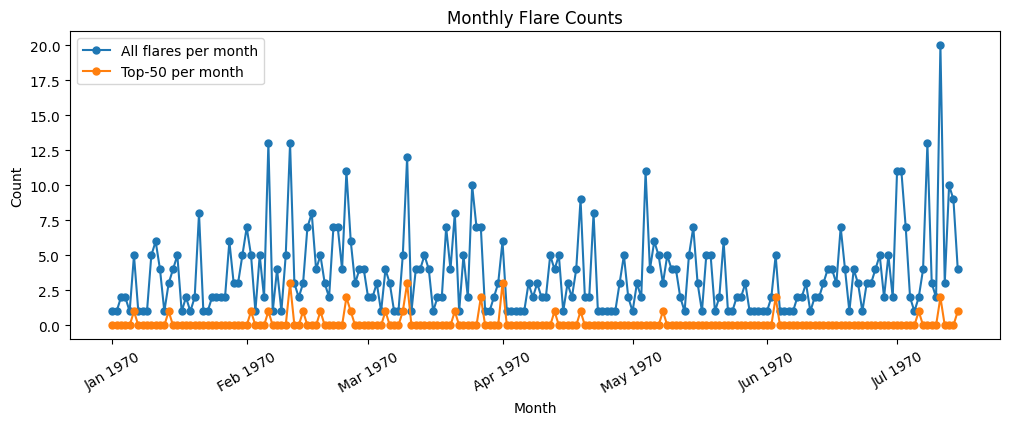

In [17]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(monthly.index, monthly["all_count"], label="All flares per month", marker="o", markersize=5)
ax.plot(monthly.index, monthly["top50_count"], label="Top-50 per month", marker="o", markersize=5)
ax.set_xlabel("Month")
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))
ax.set_ylabel("Count")
ax.set_title("Monthly Flare Counts")
ax.legend()
plt.xticks(rotation=30)
plt.show()

In the above plot, I have plotted a temporal plot of the number of flares per month over time to see if the number of strong flares (in the top 50) cluster. The blue line indicates the aggregated flares per month of all NASA data, while the orange line represents only the top-50 flares in NASA which correspond to similar flares in SpaceWeatherLive for each month. According to the plot, the orange plot peaks when the blue line peaks, showing co-variance In other words, the strong flares are not evenly distributed in time, but are skewed towards months with high solar activity.